In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from numbers_parser import Document
import pyarrow

In [5]:
# PARTIE 1.1 — Chargement & aperçu

plt.rcParams.update({"figure.figsize": (8, 4.5), "axes.grid": True})

CSV_PATH = Path("../Traitement-de-donnee/cac40.csv")
NUM_PATH = Path("../Traitement-de-donnee/close_cac40.numbers")

def read_csv_tolerant(p: Path):
    encodings = ["utf-8", "latin-1", "cp1252"]
    for enc in encodings:
        try:
            df = pd.read_csv(p, sep=None, engine="python", decimal=',', encoding=enc, low_memory=False)
            return df
        except Exception:
            continue
    return pd.read_csv(p)

csv_df = read_csv_tolerant(CSV_PATH)
print("[CSV]", "| shape:", csv_df.shape)
display(csv_df.head(10))

print("\nDtypes CSV:")
print(csv_df.dtypes)


[CSV] | shape: (533, 7)


,Date,Index,Open,High,Low,Close,Volume
0,2023-07-10,CAC40,990.15,997.11,988.11,988.56,123386.0
1,2023-01-20,CAC40,999.39,1003.24,999.08,998.35,163972.0
2,2023-04-03,CAC40,991.58,992.67,989.91,989.29,867344.0
3,2024-04-26,CAC40,NaN,1006.47,1001.66,1003.24,792459.0
4,2024-04-19,CAC40,1007.91,1009.4,1001.94,1002.77,943556.0
5,2023-11-20,CAC40,1000.79,1012.39,1000.68,999.60,362091.0
6,2023-02-02,CAC40,997.61,999.34,995.43,995.43,223099.0
7,2024-11-19,CAC40,1009.10,1011.76,1004.84,1008.07,434923.0
8,2024-05-08,CAC40,1006.18,1012.18,1002.44,1001.58,NaN
9,2023-06-05,CAC40,986.35,989.79,984.19,988.64,690189.0



Dtypes CSV:
Date       object
Index      object
Open      float64
High       object
Low        object
Close     float64
Volume    float64
dtype: object


In [4]:
#PARTIE 1.2 — Nettoyage et mise en forme ===

def mem_bytes(df: pd.DataFrame) -> int:
    return int(df.memory_usage(deep=True).sum())

def human_bytes(n: int) -> str:
    for u in ["B","KB","MB","GB","TB"]:
        if n < 1024: 
            return f"{n:.2f} {u}"
        n /= 1024
    return f"{n:.2f} PB"


def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    rename = {}
    for c in df.columns:
        cl = str(c).strip().lower()
        if cl in {"date","timestamp","time","datetime"}: rename[c] = "Date"
        elif cl in {"close","close price","cloture","cours de clôture","closing"}: rename[c] = "Close"
        elif cl in {"open","ouverture"}: rename[c] = "Open"
        elif cl in {"high","haut","max"}: rename[c] = "High"
        elif cl in {"low","bas","min"}: rename[c] = "Low"
        elif cl in {"volume","vol"}: rename[c] = "Volume"
        elif cl in {"index","indice"}: rename[c] = "Index"
    return df.rename(columns=rename)


raw_df = csv_df.copy()
raw_df = standardize_columns(raw_df)

before_shape = raw_df.shape
before_mem = mem_bytes(raw_df)
missing_before = raw_df.isna().sum()

if "Date" in raw_df.columns:
    raw_df["Date"] = pd.to_datetime(raw_df["Date"], errors="coerce", dayfirst=True)
for col in ["Open","High","Low","Close","Volume","Index"]:
    if col in raw_df.columns:
        raw_df[col] = pd.to_numeric(raw_df[col], errors="coerce")

df = raw_df.copy()

rows_before_na = len(df)
subset_cols = [c for c in ["Date","Close"] if c in df.columns]
df = df.dropna(subset=subset_cols)
rows_dropped_na = rows_before_na - len(df)

dups_before = df.duplicated(subset=["Date"]).sum() if "Date" in df.columns else 0
df = df.sort_values("Date").drop_duplicates(subset=["Date"], keep="last")

if "Date" in df.columns:
    df["Gap_Days"] = df["Date"].diff().dt.days
    gaps = df[df["Gap_Days"] > 3][["Date","Gap_Days"]]
else:
    gaps = pd.DataFrame(columns=["Date","Gap_Days"])


after_shape = df.shape
after_mem = mem_bytes(df)
missing_after = df.isna().sum()

print("---RAPPORT DE NETTOYAGE---")
print(f"- Lignes initiales : {before_shape[0]} | après nettoyage : {after_shape[0]}")
print(f"- Colonnes : {before_shape[1]} -> {after_shape[1]}")
print(f"- Lignes supprimées (NaN critiques) : {rows_dropped_na}")
print(f"- Doublons supprimés : {dups_before}")
print(f"- Gaps > 3 jours : {len(gaps)}")
if len(gaps) > 0:
    print("  Aperçu des gaps :")
    display(gaps.head(10))
print(f"- Mémoire avant : {human_bytes(before_mem)} | après : {human_bytes(after_mem)}")
print(f"- Gain : {human_bytes(before_mem - after_mem)}")
print("\nRésumé des valeurs manquantes (avant → après) :")
for col in raw_df.columns:
    before = missing_before.get(col, 0)
    after = missing_after.get(col, 0) if col in missing_after else "supprimée"
    print(f"  {col:<10} : {before} → {after}")

clean_path = Path("cac40_clean_step2.csv")
df.to_csv(clean_path, index=False)
print(f"Fichier nettoyé exporté vers : {clean_path}")
display(df.head(10))

---RAPPORT DE NETTOYAGE---
- Lignes initiales : 533 | après nettoyage : 206
- Colonnes : 7 -> 8
- Lignes supprimées (NaN critiques) : 322
- Doublons supprimés : 5
- Gaps > 3 jours : 24
  Aperçu des gaps :


,Date,Gap_Days
305,2023-02-01,20.0
515,2023-03-01,18.0
80,2023-04-01,21.0
208,2023-05-01,19.0
91,2023-06-01,20.0
467,2023-07-02,20.0
322,2023-08-02,21.0
94,2023-09-01,20.0
383,2023-10-01,20.0
148,2023-11-01,21.0


- Mémoire avant : 145.74 KB | après : 14.48 KB
- Gain : 131.26 KB

Résumé des valeurs manquantes (avant → après) :
  Date       : 0 → 0
  Index      : 0 → 206
  Open       : 6 → 2
  High       : 5 → 5
  Low        : 2 → 1
  Close      : 4 → 0
  Volume     : 10 → 5
Fichier nettoyé exporté vers : cac40_clean_step2.csv


,Date,Index,Open,High,Low,Close,Volume,Gap_Days
350,2023-01-02,NaN,996.29,998.63,981.68,999.36,266782.0,NaN
503,2023-01-03,NaN,991.23,992.53,983.42,991.34,554151.0,1.0
145,2023-01-05,NaN,986.32,988.43,984.63,990.25,592750.0,2.0
250,2023-01-06,NaN,992.25,1000.46,984.65,992.80,225829.0,1.0
238,2023-01-08,NaN,985.43,988.20,982.87,985.12,719003.0,2.0
313,2023-01-09,NaN,988.76,994.70,982.95,987.71,700600.0,1.0
19,2023-01-11,NaN,997.05,1001.65,995.50,1002.50,922614.0,2.0
140,2023-01-12,NaN,1004.54,1011.20,996.64,999.28,349265.0,1.0
305,2023-02-01,NaN,1001.64,1004.90,998.99,1001.74,440686.0,20.0
6,2023-02-02,NaN,997.61,999.34,995.43,995.43,223099.0,1.0


Index(['Date', 'Index', 'Open', 'High', 'Low', 'Close', 'Volume', 'Gap_Days'], dtype='object')


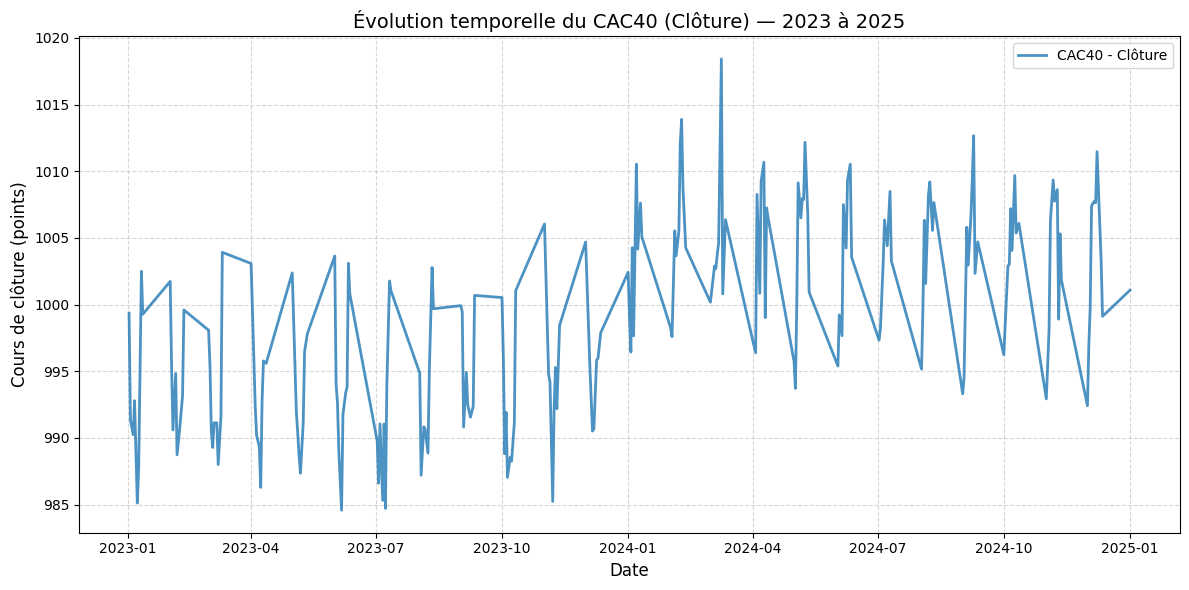

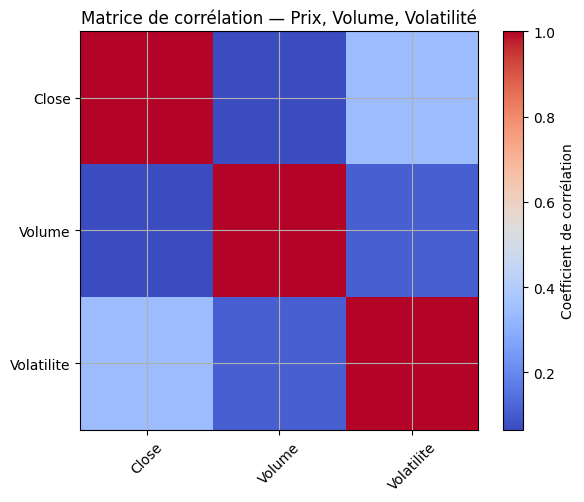

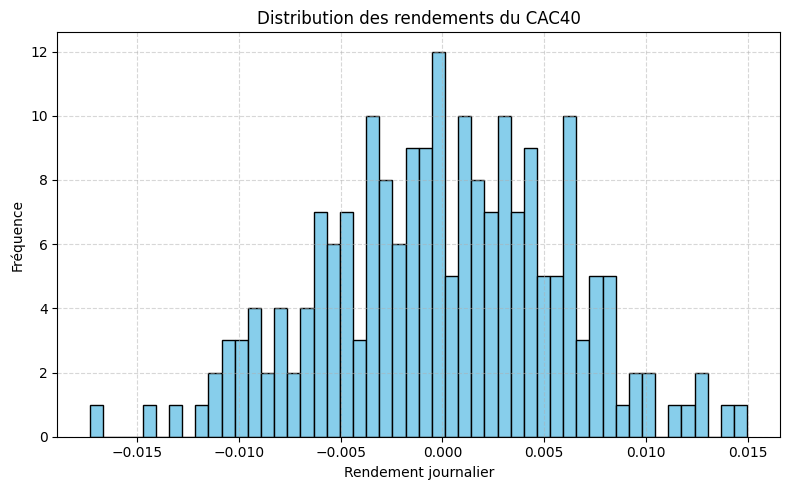

        Rendement  Volatilite
count  205.000000  176.000000
mean     0.000025    0.005914
std      0.005822    0.000640
min     -0.017301    0.004727
25%     -0.003687    0.005486
50%      0.000000    0.005757
75%      0.004138    0.006163
max      0.014974    0.007506


In [9]:
# Partie 1.3 - Analyse de base 

df = pd.read_csv("cac40_clean_step2.csv")
print(df.columns)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='CAC40 - Clôture', linewidth=2, color='tab:blue', alpha=0.8)
plt.title("Évolution temporelle du CAC40 (Clôture) — 2023 à 2025", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cours de clôture (points)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

df['Rendement'] = df['Close'].pct_change()

df['Volatilite'] = df['Rendement'].rolling(window=30).std()

cols_to_corr = ['Close', 'Volume', 'Volatilite']
corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Coefficient de corrélation")
plt.xticks(range(len(cols_to_corr)), cols_to_corr, rotation=45)
plt.yticks(range(len(cols_to_corr)), cols_to_corr)
plt.title("Matrice de corrélation — Prix, Volume, Volatilité")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df['Rendement'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution des rendements du CAC40")
plt.xlabel("Rendement journalier")
plt.ylabel("Fréquence")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(df[['Rendement', 'Volatilite']].describe())